<a href="https://colab.research.google.com/github/Tzoll87/Codes/blob/master/Rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

Id - an Id that represents a (Store, Date) duple within the test set
Store - a unique Id for each store
Sales - the turnover for any given day (this is what you are predicting)
Customers - the number of customers on a given day
Open - an indicator for whether the store was open: 0 = closed, 1 = open
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
StoreType - differentiates between 4 different store models: a, b, c, d
Assortment - describes an assortment level: a = basic, b = extra, c = extended
CompetitionDistance - distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
Promo - indicates whether a store is running a promo on that day
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
store = pd.read_csv("store.csv")

In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store["competition_open"] = pd.to_datetime(dict(year = store["CompetitionOpenSinceYear"], month = store["CompetitionOpenSinceMonth"], day = 1))

In [ ]:
#Transforming original datasets promotion columns to datetime
def date_change(x):
    if x["Promo2"] == 1:
        x["Promo2SinceYear"] = str(int(x["Promo2SinceYear"]))
        x["Promo2SinceWeek"] = str(int(x["Promo2SinceWeek"]))
        x["PromoStart"] = x["Promo2SinceYear"]+"-"+x["Promo2SinceWeek"]
        val = datetime.datetime.strptime(x["PromoStart"] + '-1', '%G-%V-%u')
        return val

In [ ]:
store["Promo2_start"] = store.apply(lambda x: date_change(x), axis = 1)

In [ ]:
#Checking if it makes sense to keep Assortment column or if it shows overlap with StoreType
store.pivot_table(index = "StoreType", columns = "Assortment", values = "Store", aggfunc = "count")

Assortment,a,b,c
StoreType,,,
a,381.0,NaN,221.0
b,7.0,9.0,1.0
c,77.0,NaN,71.0
d,128.0,NaN,220.0


In [ ]:
#Keeping only columns to be used
cols_to_use =['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'Promo2','PromoInterval','competition_open', 'Promo2_start']

In [ ]:
store_df = store[cols_to_use]

In [ ]:
sales = pd.read_csv("train.csv", parse_dates = ["Date"])

In [ ]:
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales.shape

(1017209, 9)

In [ ]:
#See if SchoolHoliday effects the sales or not
changer = sales.groupby("SchoolHoliday").agg({"Sales":"sum", "Date": "nunique"})

In [ ]:
changer["val"] = changer["Sales"] / changer["Date"]

In [ ]:
changer

,Sales,Date,val
SchoolHoliday,,,
0,4696260531,906,5.183511e+06
1,1176920092,478,2.462176e+06


In [ ]:
train = sales.merge(store_df, on = "Store", how = "inner")

In [ ]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,competition_open,Promo2_start
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT


In [ ]:
#Creating promotion related variables based on dates
train["has_comp"] = np.where(train.Date > train.competition_open, 1, 0)
train["const_promo"] = np.where(train.Date > train.Promo2_start, 1, 0)

In [ ]:
train.dtypes

Store                           int64
DayOfWeek                       int64
Date                   datetime64[ns]
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                   object
SchoolHoliday                   int64
StoreType                      object
Assortment                     object
CompetitionDistance           float64
Promo2                          int64
PromoInterval                  object
competition_open       datetime64[ns]
Promo2_start           datetime64[ns]
has_comp                        int64
const_promo                     int64
dtype: object

In [ ]:
train["Month"] = train["Date"].dt.month

In [ ]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,competition_open,Promo2_start,has_comp,const_promo,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT,1,0,7
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT,1,0,7
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT,1,0,7
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT,1,0,7
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,0,NaN,2008-09-01,NaT,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,0,1,1
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,0,1,1
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,0,1,1
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,0,1,1


In [ ]:
import calendar

In [ ]:
def cal_mon(x):
    val = x["Month"]
    return calendar.month_name[val]

In [ ]:
train["month_name"] = train.apply(lambda x: cal_mon(x), axis = 1)

In [ ]:
#Creating variable to highlight if a constant promotion is running in the store in the given date
def promo_check(x):
    lista = x["PromoInterval"]
    if x["const_promo"] == 1:
        if x["month_name"] in lista:
            return 1
        else:
            return 0

In [ ]:
train["is_const_promo_date"] = train.apply(lambda x: promo_check(x), axis = 1)

In [ ]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval', 'competition_open',
       'Promo2_start', 'has_comp', 'const_promo', 'Month', 'month_name',
       'is_const_promo_date'],
      dtype='object')

In [ ]:
train_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval', 'competition_open',
       'Promo2_start', 'has_comp','is_const_promo_date']

In [ ]:
train_df = train[train_cols]

In [ ]:
maxi = train_df.Date.max()

In [ ]:
mini = train_df.Date.min()

In [ ]:
maxi - mini

Timedelta('941 days 00:00:00')

In [ ]:
train_df = train_df.set_index("Date")

In [ ]:
#Let's check for seasonality in aggregated data to see if any adjustments are needed at that level

In [ ]:
weekly = train_df.groupby(["Date"]).sum().resample("W").mean()["Sales"]

<Axes: xlabel='Date'>

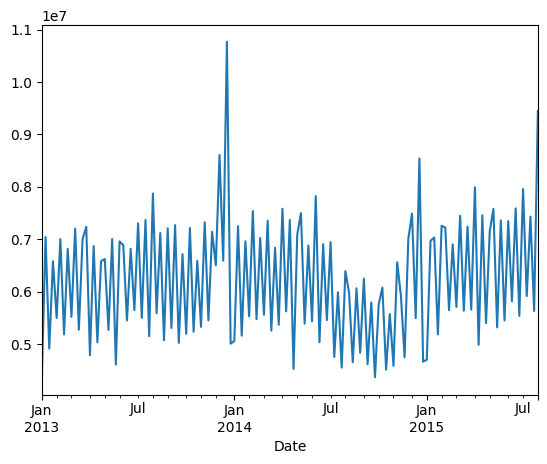

In [ ]:
weekly.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

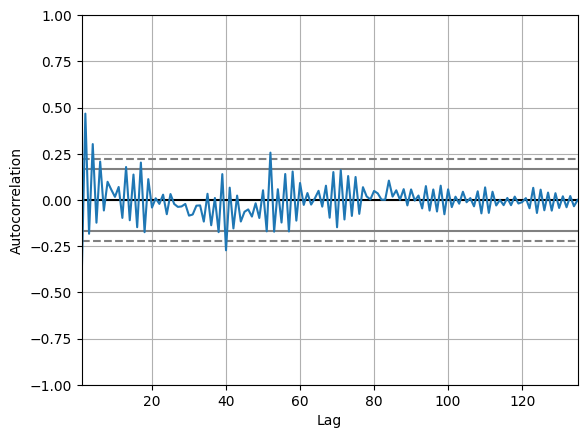

In [ ]:
pd.plotting.autocorrelation_plot(weekly)

In [ ]:
train_df["Sales"] = train_df["Sales"].astype(float)

In [ ]:
#Checking stationarity for dataset
def test_stationarity(ts):
    roll_mean = ts.rolling(window = 7).mean()
    roll_std = ts.rolling(window = 7).std()
    normal = plt.plot(ts.resample("W").mean(), color = "blue", label = "Original")
    mean = plt.plot(roll_mean.resample("W").mean(), color = "red", label = "Rolling mean")
    std = plt.plot(roll_std.resample("W").mean(), color = "green", label = "Rolling std")
    plt.legend(loc = "best")
    plt.show()
    
    # Perform Dicky-Fuller test for analysing strength of stationarity
    result = adfuller(ts, autolag = 'AIC')
    print('ADF Statistic: %f' % result[0])
    print('p_value: %f:' % result[1])

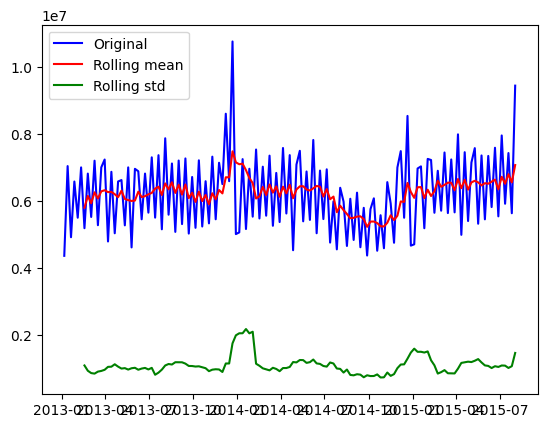

ADF Statistic: -3.524359
p_value: 0.007383:


In [ ]:
test_stationarity(weekly)

In [ ]:
#Analysing seasonality and trend
def seas_trend(ts):
    fig, axes = plt.subplots(2, 1, sharex = False, sharey= False)
    decomp = seasonal_decompose(ts, model = 'additive')
    trend = decomp.trend
    seas = decomp.seasonal
    res = decomp.resid
    
    axes[1].plot(seas, 'g', label = 'Seasonality')
    axes[1].legend(loc = "upper left");
    
    axes[0].plot(trend, 'b', label = 'Trend')
    axes[0].legend(loc = "upper left");

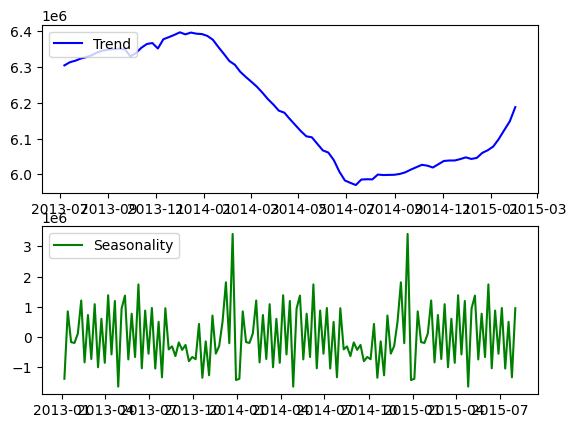

In [ ]:
seas_trend(weekly)

In [ ]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval', 'competition_open',
       'Promo2_start', 'has_comp', 'is_const_promo_date'],
      dtype='object')

In [ ]:
#How does the trends look like comparing different type of stores?
store_type = pd.DataFrame(train_df.groupby(["Date","StoreType"])["Sales"].sum()).reset_index().set_index("Date")

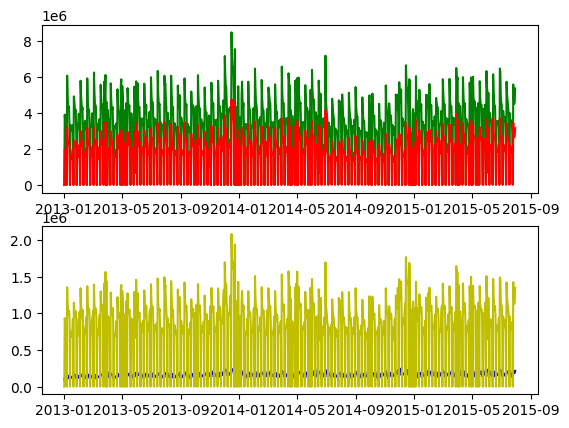

In [ ]:
#By visualization, we can see that the trend is mostly the same regardless of the store type
fig, axes = plt.subplots(2, 1, sharex = False, sharey= False)
axes[0].plot(store_type[store_type["StoreType"] == "a"]["Sales"], "g")
axes[1].plot(store_type[store_type["StoreType"] == "b"]["Sales"], "b")
axes[1].plot(store_type[store_type["StoreType"] == "c"]["Sales"], "y")
axes[0].plot(store_type[store_type["StoreType"] == "d"]["Sales"], "r")
plt.show()

In [ ]:
train_df.Store.value_counts()

1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: Store, Length: 1115, dtype: int64

In [ ]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval', 'competition_open',
       'Promo2_start', 'has_comp', 'is_const_promo_date'],
      dtype='object')

In [ ]:
for_train = ['Store', 'Sales', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday','CompetitionDistance', 'Promo2', 'has_comp', 'is_const_promo_date']

In [ ]:
sales = train_df[for_train]

In [ ]:
sales = sales.fillna(0)

In [ ]:
sales.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
sales["StateHoliday"] = np.where((sales.StateHoliday == "a") | (sales.StateHoliday == "b") | (sales.StateHoliday == "c"), 1, 0)

In [ ]:
sales.StateHoliday.value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

In [ ]:
#We can see the data has both seasonality and trend factors, hence models would calculate with these accordingly
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p,d,q))]

In [ ]:
sales = sales.sort_index()

In [ ]:
trainers = [1, 726, 708]

In [ ]:
import statsmodels.api as sm

In [ ]:
#Iterating through SARIMA parameters for a few stores to identify the best possible combination..
#and after train model on training dataset accordingly
for item in trainers:
    sales2 = sales[sales["Store"] == item]
    sales_df = sales2.drop("Store", axis = 1)
    best_aic = 10000000
    best_parameters = ()
    best_seasonal = ()
    for param in pdq:
        for param_seas in seasonal:
            try:
                mod = sm.tsa.statespace.SARIMAX(endog = sales_df["Sales"], exog = sales_df[['Open', 'Promo',
       'StateHoliday', 'SchoolHoliday','CompetitionDistance', 'Promo2', 'has_comp', 'is_const_promo_date']], order = param, seasonal_order = param_seas, enforce_stationarity = False, enforce_invertibility = False)
                result = mod.fit()
                aic = result.aic
                normal = param
                seas = param_seas
                if aic < best_aic:
                    best_aic = aic
                    best_parameters = normal
                    best_seasonal = param_seas
                    print(f"{best_parameters}, {best_seasonal} had the best aic score with {aic}")
            except:
                continue
    print(f"For store {item} the best combination was {best_parameters}, {best_seasonal}")

(0, 0, 0)
(0, 0, 0), (0, 0, 0, 365) had the best aic score with 15294.74720538529
(0, 0, 0)


In [ ]:
sales = sales.drop("CompetitionDistance", axis = 1)

In [ ]:
stores = sales.Store.unique()

In [ ]:
#To select specific store, filter for store id
sales_df = sales[sales["Store"] == 1].drop("Store", axis = 1)

In [ ]:
def predictor(store):
    train_x = store[store.index <= "2015-06-01"]
    test_x = store[store.index > "2015-06-01"]
    model_sarima = sm.tsa.statespace.SARIMAX(endog = train_x["Sales"], exog = train_x[['Open', 'Promo',
       'StateHoliday', 'SchoolHoliday','Promo2', 'has_comp', 'is_const_promo_date']], order = (0,1,1), seasonal_order = (1,1,1,365), enforce_stationarity = False, enforce_invertibility = False)
    res_sarima = model_sarima.fit()
    forecast_exog = test_x[['Open', 'Promo',
       'StateHoliday', 'SchoolHoliday','Promo2', 'has_comp', 'is_const_promo_date']]
    prediction = res_sarima.predict(start = test_x.index[0], end = test_x.index[-1])
    
    forecast = []
    for item in prediction:
        if item < 0:
            forecast.append(0)
        else:
            forecast.append(item)
    
    rmse = np.sqrt(((forecast / test_x["Sales"]) ** 2).mean())
    print(rmse)

In [ ]:
predictor(sales_df)